In [19]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf
import umap
import warnings

from dirichlet import mle
from scipy.stats import dirichlet
from sklearn.manifold import TSNE
from synthetic_data.wgan.utils import CustomHistory
from synthetic_data.wgan.critics import MLPCritic
from synthetic_data.wgan.generators import MLPGenerator
from synthetic_data.wgan.wgan import WGANGP, critic_loss, generator_loss


warnings.filterwarnings("ignore")
np.set_printoptions(suppress=True)

tf.__version__

'2.13.0'

# Dirichlet samples

In [2]:
for filename in glob.glob("data\\experimental\\classification\\001points\\*train*"):
    df = pd.read_csv(filename)
    compositions = df.iloc[:, df.columns.str.contains("z")].drop_duplicates() / 100.0
    alpha = mle(compositions)
    break

# Wasserstein GAN samples

In [3]:
# Training WGAN
latent_dim = 16
lambda_ = 10.0
n_critic = 5
lr = 0.0001
beta_1, beta_2 = 0.5, 0.9
batch_size = 32
epochs = 3000

output_dim = compositions.shape[-1]

print(f"samples, features: {compositions.values.shape}", end="\n\n")
data = compositions.values.astype(np.float32)
dataset = tf.data.Dataset.from_tensor_slices(data)
dataset = dataset.batch(batch_size)

critic = MLPCritic(hidden_units=[512, 512, 512])
generator = MLPGenerator(output_dim=output_dim, hidden_units=[512, 512, 512])

critic_optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr,
    beta_1=beta_1,
    beta_2=beta_2,
)
generator_optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr,
    beta_1=beta_1,
    beta_2=beta_2,
)

random_latent_vectors = tf.random.normal((440, latent_dim))

# Get the Wasserstein GAN model
wgan = WGANGP(
    critic=critic,
    generator=generator,
    latent_dim=latent_dim,
    n_critic=n_critic,
    lambda_=lambda_,
)

# Compile the Wasserstein GAN model
wgan.compile(
    critic_optimizer=critic_optimizer,
    generator_optimizer=generator_optimizer,
    critic_loss_fn=critic_loss,
    generator_loss_fn=generator_loss,
)

callbacks = [CustomHistory()]

wgan.fit(dataset, epochs=epochs, callbacks=callbacks)

neg_critic_loss = -np.array(callbacks[0].history["critic_loss"])
batches = neg_critic_loss.shape[0]


samples, features: (440, 24)

Epoch 1/2000
14/14 [==============================] - 3s 63ms/step - critic_loss: 0.7410 - generator_loss: 0.0422
Epoch 2/2000
14/14 [==============================] - 1s 63ms/step - critic_loss: -0.2300 - generator_loss: -0.0813
Epoch 3/2000
14/14 [==============================] - 1s 64ms/step - critic_loss: -0.1590 - generator_loss: 0.0712
Epoch 4/2000
14/14 [==============================] - 1s 63ms/step - critic_loss: -0.0660 - generator_loss: -0.0855
Epoch 5/2000
14/14 [==============================] - 1s 65ms/step - critic_loss: -0.0705 - generator_loss: 0.2059
Epoch 6/2000
14/14 [==============================] - 1s 63ms/step - critic_loss: -0.0535 - generator_loss: 0.0820
Epoch 7/2000
14/14 [==============================] - 1s 64ms/step - critic_loss: -0.0508 - generator_loss: 0.0587
Epoch 8/2000
14/14 [==============================] - 1s 64ms/step - critic_loss: -0.0408 - generator_loss: 0.1044
Epoch 9/2000
14/14 [=============================

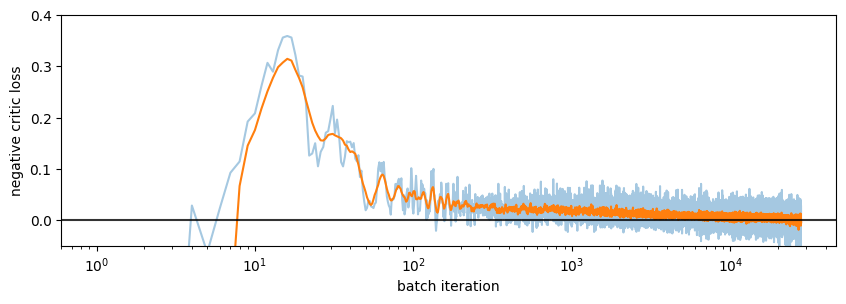

In [17]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(np.arange(batches), neg_critic_loss, alpha=0.4)
ax.plot(np.arange(batches), pd.Series(neg_critic_loss).rolling(10, center=True).mean())
ax.set_xlabel("batch iteration")
ax.set_ylabel("negative critic loss")
ax.set_ylim([-0.05, 0.4])
ax.axhline(y=0.0, color=('black', 0.8), linestyle='-')

# ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

In [5]:
samples_size = compositions.shape[0]
noise = tf.random.normal([samples_size, 16])

data = np.vstack(
    [
        compositions.values,
        dirichlet.rvs(alpha, size=samples_size),
        generator(noise, training=False),
    ]
)


tsne = TSNE(n_components=2, perplexity=100)
umap_ = umap.UMAP(n_neighbors=50, n_components=2, metric="euclidean", min_dist=0.1)

reduced_tsne = tsne.fit_transform(data)
reduced_umap = umap_.fit_transform(data)

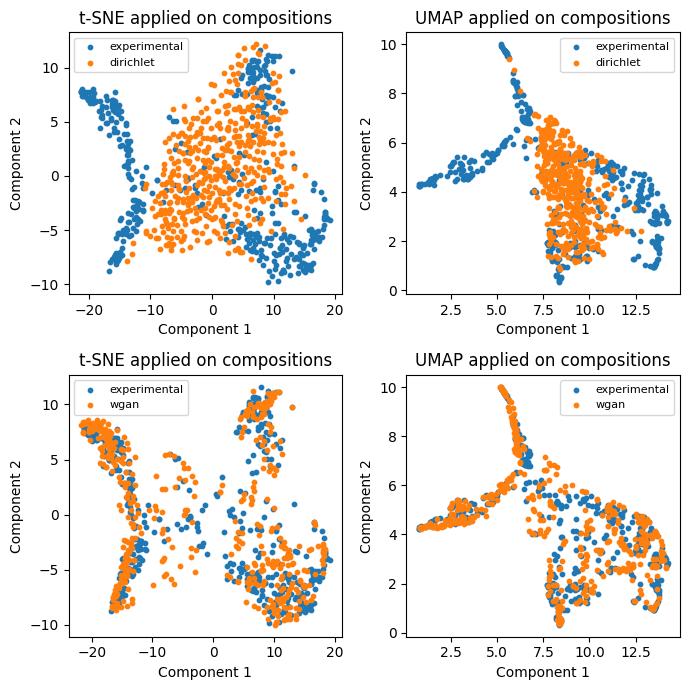

In [25]:
def dim_reduction_plots(*projections):
    f, ax = plt.subplots(2, 2, figsize=(7, 7))
    
    for j, proj in enumerate(projections):
        ax[0, j].scatter(
            proj["samples"][:samples_size, 0],
            proj["samples"][:samples_size, 1],
            s=10,
            label="experimental",
        )
        ax[0, j].scatter(
            proj["samples"][samples_size : 2 * samples_size, 0],
            proj["samples"][samples_size : 2 * samples_size, 1],
            s=10,
            label="dirichlet",
        )
        ax[0, j].legend(prop={"size": 8})
        ax[0, j].set_xlabel("Component 1")
        ax[0, j].set_ylabel("Component 2")
        ax[0, j].set_title(f"{proj['method']} applied on compositions")

        ax[1, j].scatter(
            proj["samples"][:samples_size, 0],
            proj["samples"][:samples_size, 1],
            s=10,
            label="experimental",
        )
        ax[1, j].scatter(
            proj["samples"][2*samples_size :, 0],
            proj["samples"][2*samples_size :, 1],
            s=10,
            label="wgan",
        )
        ax[1, j].legend(prop={"size": 8})
        ax[1, j].set_xlabel("Component 1")
        ax[1, j].set_ylabel("Component 2")
        ax[1, j].set_title(f"{proj['method']} applied on compositions")

    f.tight_layout()
    img_filepath = os.path.join("synthetic_data", "dimensionality_reduction_samples.png")
    f.savefig(img_filepath, dpi=600)
    plt.show()


dim_reduction_plots(*({"samples": reduced_tsne, "method": "t-SNE"}, {"samples": reduced_umap, "method": "UMAP"}))